In [16]:
## Import packages
import pandas as pd
import numpy as np
import plotly
from sqlalchemy import create_engine
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import lxml

In [17]:
engine = create_engine('sqlite:///%s' % '../data/coviddb')
df = pd.read_sql_table('CovidData', engine)

In [18]:
df.shape

(497, 34)

In [19]:
df.head()

,CityName,county_fips,state_id,density,ACCESS2,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,...,MAMMOUSE,MHLTH,OBESITY,PAPTEST,PHLTH,SLEEP,STROKE,TEETHLOST,case1m,death1m
0,Abilene,48441,TX,441.0,22.60,24.30,17.60,31.10,68.00,5.90,...,73.45,13.20,35.10,77.80,13.30,33.55,3.25,15.65,2648.300808,40.370439
1,Akron,39153,OH,1233.0,12.40,28.95,15.45,36.40,71.70,6.05,...,73.10,15.55,36.10,79.55,15.15,43.15,4.15,21.55,1709.592780,207.080750
2,Alameda,6001,CA,2927.0,7.50,17.90,17.85,24.80,63.00,5.85,...,77.90,9.75,18.30,80.60,9.05,33.70,2.20,7.50,2110.346137,62.869091
3,Berkeley,6001,CA,4509.0,7.40,16.55,19.20,22.70,61.00,5.45,...,79.85,10.50,19.55,82.25,8.60,32.35,2.10,6.75,2110.346137,62.869091
4,Fremont,6001,CA,1171.0,7.65,15.15,16.75,22.85,61.85,5.00,...,77.80,8.45,15.50,79.15,7.75,34.30,1.75,6.75,2110.346137,62.869091


In [119]:
cm = df.corr()[['death1m']][1:-2]

In [120]:
import plotly.express as px
fig = px.bar(x=cm.index, y=cm)
fig.update_layout(xaxis_tickangle=-45,\
    title='Measure Correlations with death1m',\
        xaxis_title='Measure',\
            yaxis_title = 'Corr')
fig.show()

In [125]:
lookup.loc[lookup['MeasureId'].isin(cm.loc[cm['death1m'] < 0].index.tolist())][['MeasureId','Measure', 'Category']].sort_values(by = 'Category')

,MeasureId,Measure,Category
17,CANCER,Cancer (excluding skin cancer) among adults aged >=18 Years,Health Outcomes
10,ACCESS2,Current lack of health insurance among adults aged 18–64 Years,Prevention
11,COLON_SCREEN,"Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50–75 Years",Prevention
21,DENTAL,Visits to dentist or dental clinic among adults aged >=18 Years,Prevention
26,COREW,"Older adult women aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 Years",Prevention
27,COREM,"Older adult men aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening",Prevention
13,BINGE,Binge drinking among adults aged >=18 Years,Unhealthy Behaviors


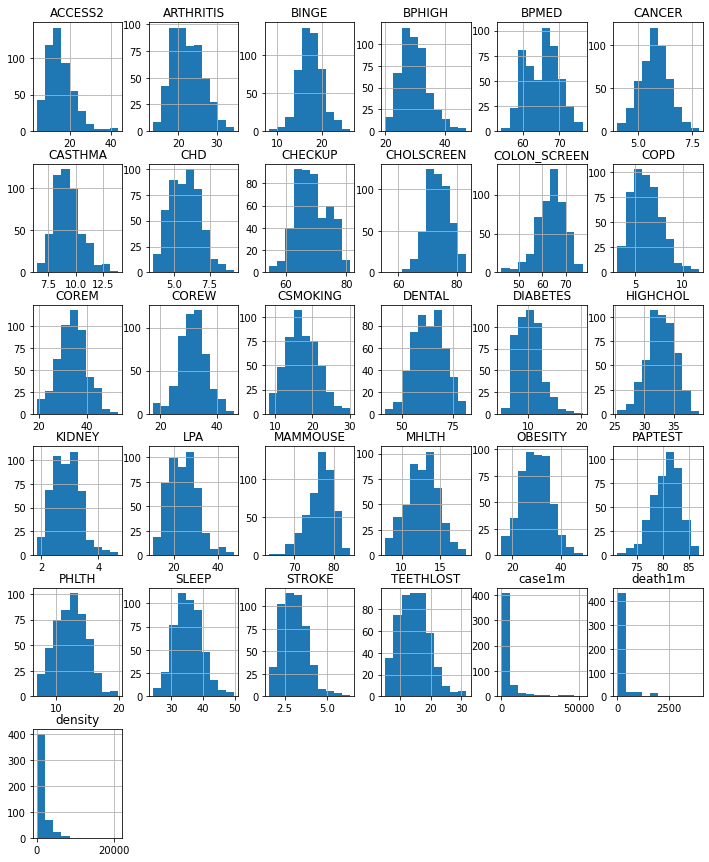

In [22]:
df.iloc[:,3:].hist(figsize = (12,15));

In [23]:
## Set X, y and split into train and test data set
X = df.drop(columns = ['county_fips','CityName','state_id','case1m', 'death1m','PAPTEST'])
y = df['death1m']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

In [24]:
##Train the model using OLS
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est = est.fit()
print(est.summary().tables[0])

OLS Regression Results                            
Dep. Variable:                death1m   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     13.51
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           3.40e-39
Time:                        00:26:02   Log-Likelihood:                -2520.5
No. Observations:                 347   AIC:                             5099.
Df Residuals:                     318   BIC:                             5211.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         


In [25]:
## Get significant variables
p = est.pvalues
significant_vars = p.loc[p < 0.10].index.tolist()

ols_coef = pd.read_html(est.summary().tables[1].as_html(),header=0,index_col=0)[0]
ols_coef.loc[ols_coef['P>|t|'] < 0.1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-3245.4204,1387.144,-2.340,0.020,-5974.559,-516.281
density,0.0683,0.016,4.172,0.000,0.036,0.100
ACCESS2,-20.1784,8.852,-2.280,0.023,-37.594,-2.763
ARTHRITIS,51.2526,21.464,2.388,0.018,9.023,93.482
CANCER,-285.3984,121.172,-2.355,0.019,-523.799,-46.997
CASTHMA,88.5298,36.961,2.395,0.017,15.810,161.249
CHECKUP,33.3058,11.344,2.936,0.004,10.988,55.624
COPD,-193.5914,76.614,-2.527,0.012,-344.326,-42.857
COREM,-19.5018,6.196,-3.147,0.002,-31.693,-7.311
DENTAL,23.6100,9.048,2.609,0.010,5.808,41.412


In [26]:
## Predict on test data
r2 = r2_score(y_test, est.predict(sm.add_constant(X_test)))
print('r2-score on test data: ', round(r2,4))

r2-score on test data:  0.2011


In [27]:
## Load measures lookup
lookup = pd.read_sql_table('MeasureLookup', engine)

In [28]:
## Get measures summary
categories = lookup.groupby('Category').agg({'MeasureId': 'count'})
categories

,MeasureId
Category,
Health Outcomes,13
Prevention,10
Unhealthy Behaviors,5


In [30]:
pd.set_option('display.max_colwidth', -1)
lookup.loc[lookup['MeasureId'].isin(significant_vars)][['MeasureId','Measure', 'Category']].sort_values(by = 'Category')

,MeasureId,Measure,Category
2,HIGHCHOL,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,Health Outcomes
7,ARTHRITIS,Arthritis among adults aged >=18 Years,Health Outcomes
8,CASTHMA,Current asthma among adults aged >=18 Years,Health Outcomes
9,DIABETES,Diagnosed diabetes among adults aged >=18 Years,Health Outcomes
17,CANCER,Cancer (excluding skin cancer) among adults aged >=18 Years,Health Outcomes
18,COPD,Chronic obstructive pulmonary disease among adults aged >=18 Years,Health Outcomes
10,ACCESS2,Current lack of health insurance among adults aged 18–64 Years,Prevention
21,DENTAL,Visits to dentist or dental clinic among adults aged >=18 Years,Prevention
23,CHECKUP,Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,Prevention
27,COREM,"Older adult men aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening",Prevention


In [36]:
significant_vars.remove('const')

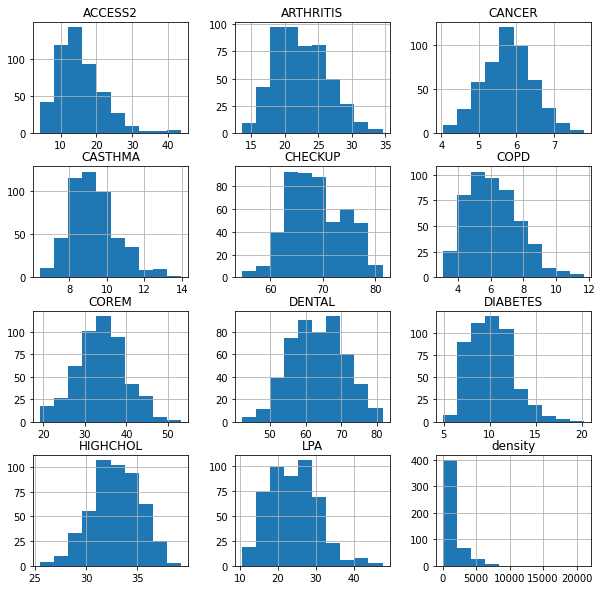

In [43]:
df[significant_vars].hist(figsize = (10,10));

In [48]:
fig = px.scatter(df, x = 'CHECKUP', y = 'death1m', hover_name="state_id", hover_data=["state_id", "CityName"])
fig.show()

In [80]:
df100 = pd.read_sql_table('Covid100', engine)

In [85]:
df100.columns

Index(['CityName', 'county_fips', 'state_id', 'density', 'ACCESS2',
       'ARTHRITIS', 'BINGE', 'BPHIGH', 'BPMED', 'CANCER', 'CASTHMA', 'CHD',
       'CHECKUP', 'CHOLSCREEN', 'COLON_SCREEN', 'COPD', 'COREM', 'COREW',
       'CSMOKING', 'DENTAL', 'DIABETES', 'HIGHCHOL', 'KIDNEY', 'LPA',
       'MAMMOUSE', 'MHLTH', 'OBESITY', 'PAPTEST', 'PHLTH', 'SLEEP', 'STROKE',
       'TEETHLOST', 'first_date', 'case1m', 'death1m', 'county_fips_number',
       'case14', 'death14'],
      dtype='object')

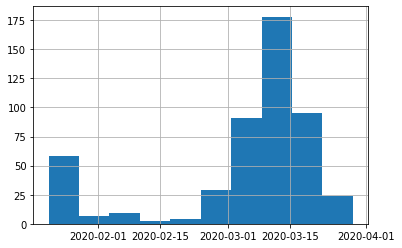

In [81]:
df100['first_date'].hist()

In [135]:
cm = df100.corr()[['death14']][2:-5]
fig = px.bar(x=cm.index, y=cm)
fig.update_layout(xaxis_tickangle=-45,\
    title='Measure Correlations with death1m',\
        xaxis_title='Measure',\
            yaxis_title = 'Corr')
fig.show()

In [71]:
fig = px.scatter(df100, x = 'state_id', y = 'CHECKUP')
fig.show()

In [93]:
fig = px.scatter(df100, x = 'first_date', y = 'case14',hover_name="state_id", hover_data=["state_id", "CityName"])
fig.show()

In [131]:
test = df100.copy()
X = test.drop(columns = ['county_fips','CityName','state_id','case1m', 'death1m','PAPTEST','first_date','county_fips_number','case14','death14'])
# y = test['death14']
y = test['death1m']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                death1m   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     13.78
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           7.04e-40
Time:                        01:11:53   Log-Likelihood:                -2542.1
No. Observations:                 347   AIC:                             5142.
Df Residuals:                     318   BIC:                             5254.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3669.9698   1476.558     -2.485      0.013   -6575.027    -764.913
density          0.0700      0.017      4.016      0.000       0.036       0.104
ACCESS2        -18.3712      9.423     -1.950      0.052     -36.910       0.167
ARTHRITIS       54.2767     22.847      2.376      0.018       9.325      99.228
BINGE          -12.5649     13.052     -0.963      0.336     -38.243      13.114
BPHIGH          -9.3097     17.197     -0.541      0.589     -43.144      24.525
BPMED            2.0126     14.572      0.138      0.890     -26.657      30.682
CANCER        -301.1822    128.983     -2.335      0.020    -554.950     -47.414
CASTHMA        101.4600     39.344      2.579      0.010      24.053     178.867
CHD            156.4860    129.306      1.210      0.227     -97.918     410.890
CHECKUP         34.2346     12.075      2.835      0.005      10.478      57.991
CHOLSCREEN      16.2200     14.540      1.116      0.265     -12.387      44.827
COLON_SCREEN    -5.4603     11.038     -0.495      0.621     -27.176      16.256
COPD          -214.9018     81.553     -2.635      0.009    -375.353     -54.451
COREM          -20.6168      6.596     -3.126      0.002     -33.593      -7.640
COREW           -9.7838      9.706     -1.008      0.314     -28.881       9.313
CSMOKING       -11.2729     22.098     -0.510      0.610     -54.749      32.204
DENTAL          28.2716      9.632      2.935      0.004       9.322      47.221
DIABETES      -220.0813     49.898     -4.411      0.000    -318.253    -121.910
HIGHCHOL        52.4393     20.434      2.566      0.011      12.237      92.642
KIDNEY         224.6004    324.608      0.692      0.489    -414.050     863.250
LPA             42.8368     14.199      3.017      0.003      14.901      70.773
MAMMOUSE       -11.3209     13.584     -0.833      0.405     -38.047      15.406
MHLTH          -56.4121     49.029     -1.151      0.251    -152.873      40.049
OBESITY        -13.7422      9.963     -1.379      0.169     -33.344       5.860
PHLTH           77.6734     58.009      1.339      0.182     -36.457     191.804
SLEEP            3.9289     12.319      0.319      0.750     -20.307      28.165
STROKE          24.2206    186.244      0.130      0.897    -342.205     390.646
TEETHLOST       24.4461     16.324      1.498      0.135      -7.670      56.562
==============================================================================
Omnibus:                      196.784   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2164.951
Skew:                           2.139   Prob(JB):                         0.00
Kurtosis:                      14.464   Cond. No.                     1.69e+05
==============================================================================

Warnings:
[1] St

In [76]:
# df100.loc[df100['death1m'] <= 2000]

In [132]:
r2 = r2_score(y_test, est.predict(sm.add_constant(X_test)))
print('r2-score on test data: ', round(r2,4))

r2-score on test data:  0.2356


In [133]:
ols_coef = pd.read_html(est.summary().tables[1].as_html(),header=0,index_col=0)[0]
ols_coef.loc[ols_coef['P>|t|'] < 0.1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-3669.9698,1476.558,-2.485,0.013,-6575.027,-764.913
density,0.0700,0.017,4.016,0.000,0.036,0.104
ACCESS2,-18.3712,9.423,-1.950,0.052,-36.910,0.167
ARTHRITIS,54.2767,22.847,2.376,0.018,9.325,99.228
CANCER,-301.1822,128.983,-2.335,0.020,-554.950,-47.414
CASTHMA,101.4600,39.344,2.579,0.010,24.053,178.867
CHECKUP,34.2346,12.075,2.835,0.005,10.478,57.991
COPD,-214.9018,81.553,-2.635,0.009,-375.353,-54.451
COREM,-20.6168,6.596,-3.126,0.002,-33.593,-7.640
DENTAL,28.2716,9.632,2.935,0.004,9.322,47.221


In [129]:
p = est.pvalues
significant_vars = p.loc[p < 0.10].index.tolist()
lookup.loc[lookup['MeasureId'].isin(significant_vars)][['MeasureId','Measure', 'Category']].sort_values(by = 'Category')

,MeasureId,Measure,Category
4,TEETHLOST,All teeth lost among adults aged >=65 Years,Health Outcomes
8,CASTHMA,Current asthma among adults aged >=18 Years,Health Outcomes
9,DIABETES,Diagnosed diabetes among adults aged >=18 Years,Health Outcomes
18,COPD,Chronic obstructive pulmonary disease among adults aged >=18 Years,Health Outcomes
25,PHLTH,Physical health not good for >=14 days among adults aged >=18 Years,Health Outcomes
10,ACCESS2,Current lack of health insurance among adults aged 18–64 Years,Prevention
11,COLON_SCREEN,"Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50–75 Years",Prevention
23,CHECKUP,Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,Prevention
27,COREM,"Older adult men aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening",Prevention
12,CSMOKING,Current smoking among adults aged >=18 Years,Unhealthy Behaviors
